In [2]:
import quandl
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd

2024-08-14 15:23:03.852080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.__version__

'2.14.0'

### 1. Data Download

In [4]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [5]:
btc = get_quandl_data('BCHARTS/KRAKENUSD')

Cached BCHARTS/KRAKENUSD at BCHARTS-KRAKENUSD.pkl


In [6]:
btc = btc[btc['High'] != 0]

In [7]:
btc.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2021-06-16,40167.3,40493.0,38120.0,38337.1,6487.206888,2.539206e+08,39141.737747
2021-06-17,38337.1,39561.4,37405.0,38078.2,6003.220618,2.307246e+08,38433.468618
2021-06-18,38078.2,38193.1,35126.0,35824.0,6558.468890,2.409217e+08,36734.445103
2021-06-19,35824.0,36450.0,34901.0,35490.5,4485.076656,1.603145e+08,35743.971502
2021-06-20,35484.2,36112.2,33370.0,35668.7,6229.513564,2.168125e+08,34804.086189


### 2. Plot series and split into trainng/validation

In [8]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    size = plt.gcf()
    size.set_size_inches(18,7)
    plt.grid(False)
    plt.rc({'font_size' : 18})
    plt.rcParams.update({'font.size' : 18})
    plt.show()


In [9]:
series = btc['High'][1100:]

In [10]:
time = np.arange(1,len(series)+1)

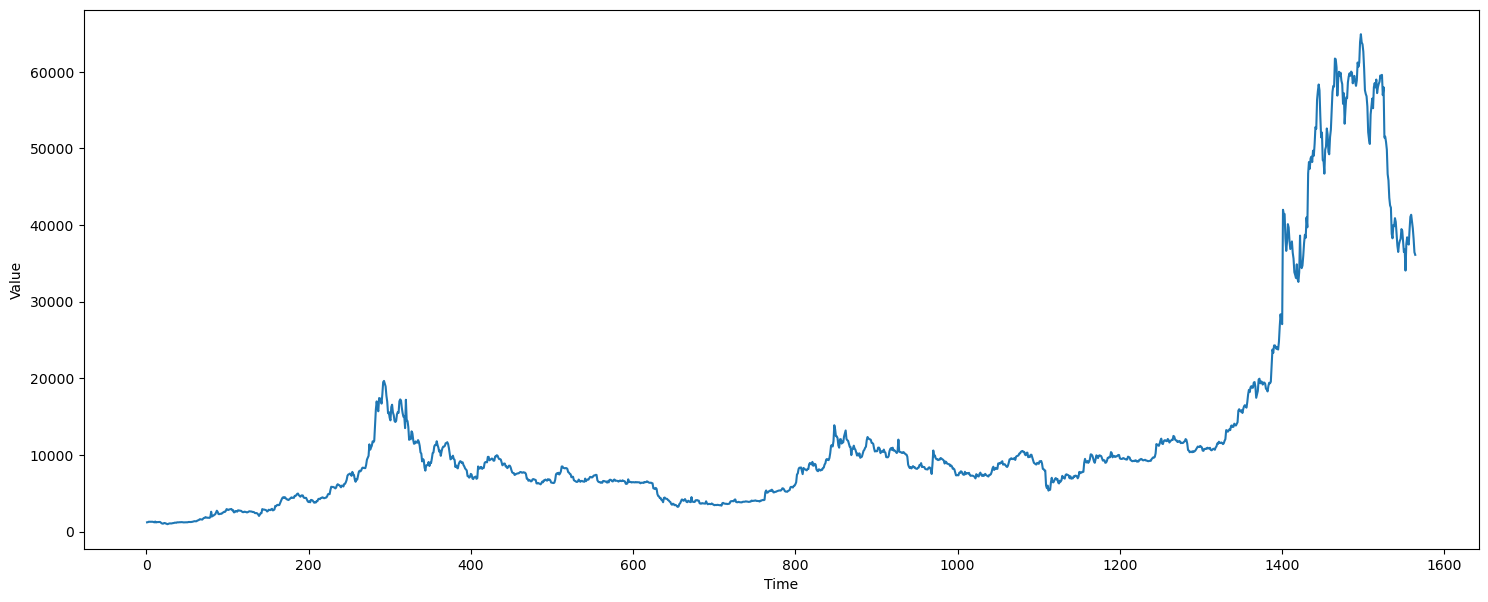

In [11]:
plot_series(time,series)

In [12]:
split_time = 600
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

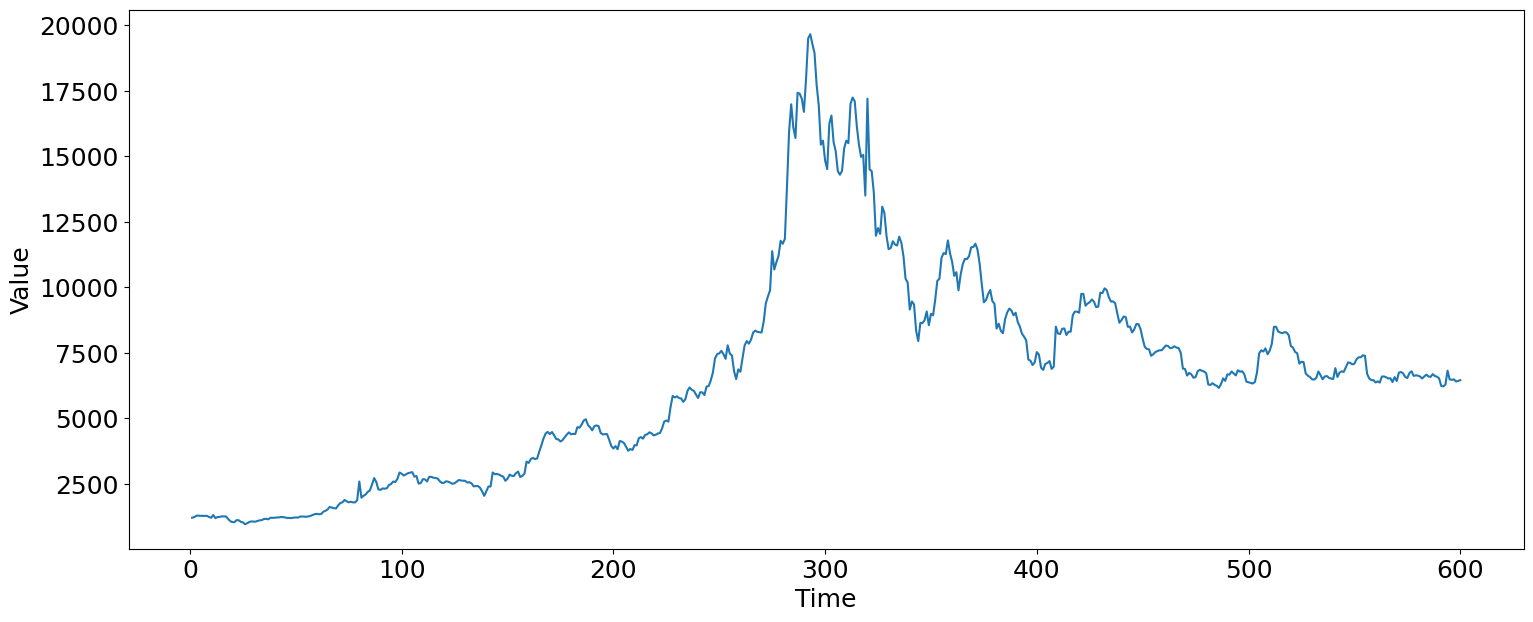

In [13]:
plot_series(time_train, x_train)

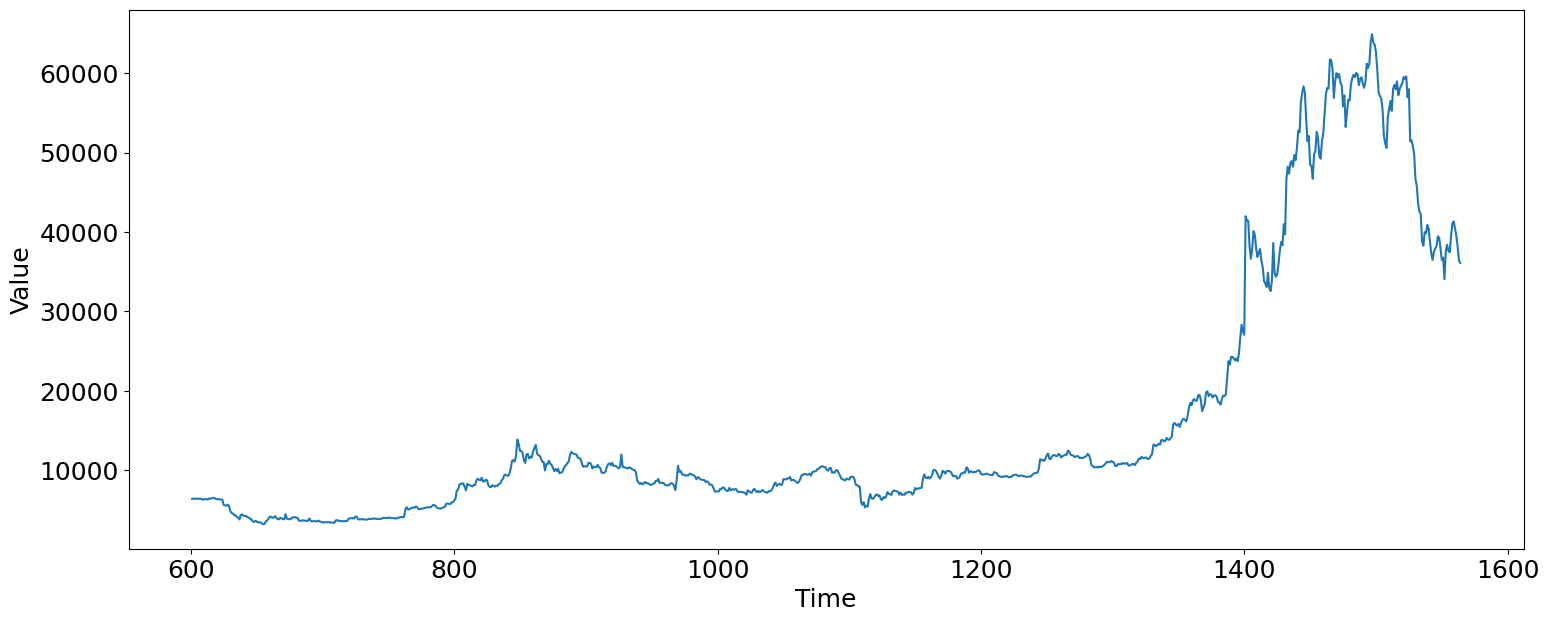

In [14]:
plot_series(time_valid, x_valid)

### 3. Autocorrelation

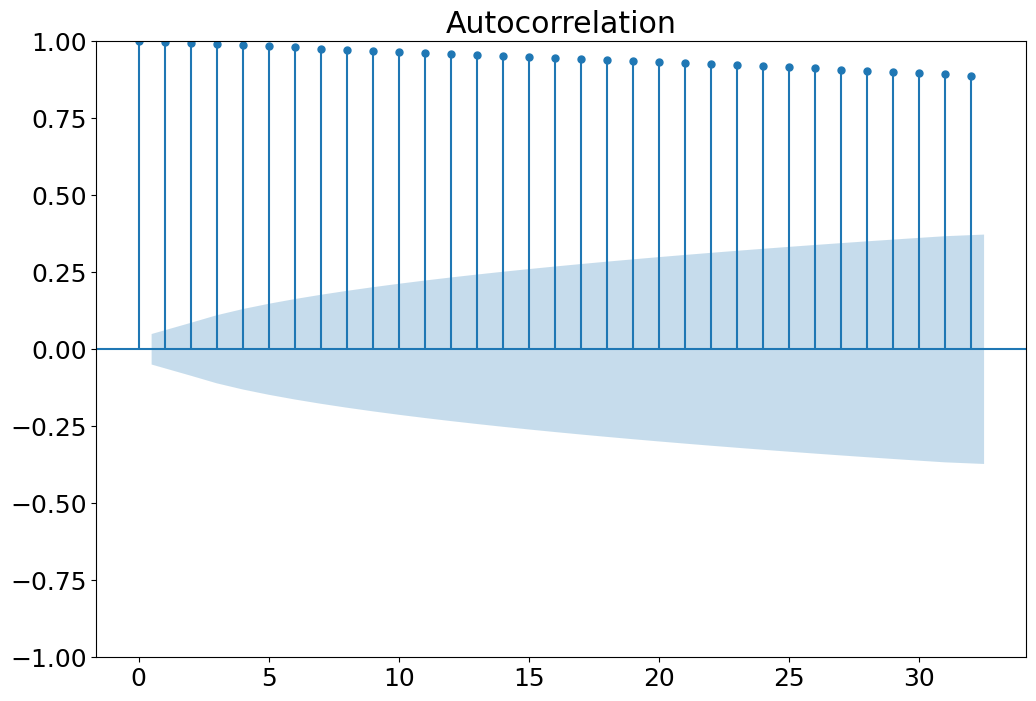

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series)

size = plt.gcf()
size.set_size_inches(12,8)
plt.show()

### 4. Partial Autocorrelation

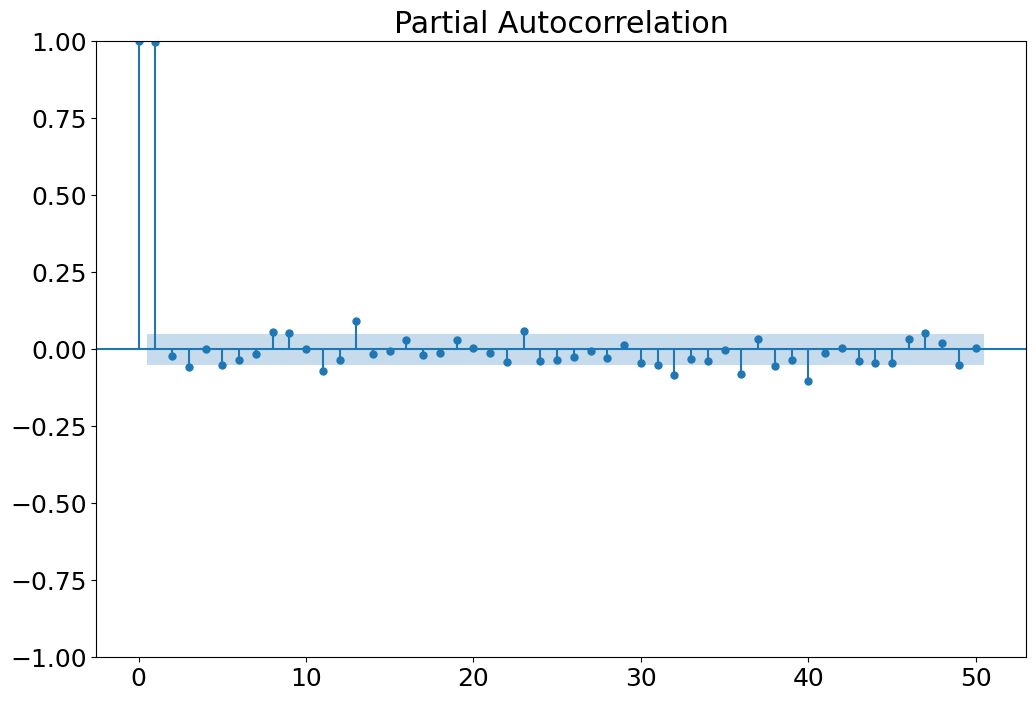

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(series, lags=50)

size = plt.gcf()
size.set_size_inches(12,8)
plt.show()

### 5. Time Series Decomposition

<Figure size 1600x2000 with 0 Axes>

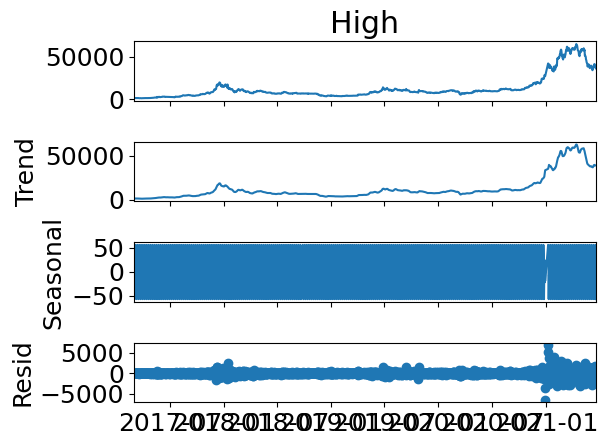

In [19]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'series' is a pandas Series with a datetime index
# Replace 'series' with your actual time series data
# Example: series = pd.Series(...)

# Perform seasonal decomposition
result = seasonal_decompose(series, model='additive', period=7)

# Set up the plot size
plt.figure(figsize=(16, 20))

# Plot the decomposition
result.plot()

# Show the plot
plt.show()


<Figure size 1600x2000 with 0 Axes>

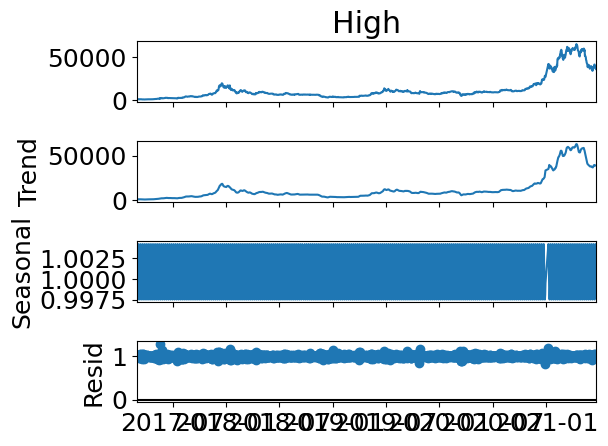

In [21]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'series' is a pandas Series with a datetime index
# Replace 'series' with your actual time series data

# Perform seasonal decomposition (using multiplicative model)
result = seasonal_decompose(series, model='multiplicative', period=7)  # Adjust period as needed

# Plot the decomposition results with a larger figure size
fig = plt.figure(figsize=(16, 20))
result.plot()
plt.show()


### 6. Stationarity Test

In [22]:
from statsmodels.tsa.stattools import adfuller
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.632616
p-value: 0.863441
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


### 7. Naive Forecast

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt

p=1 RMSE:942.296
p=2 RMSE:1352.649
p=3 RMSE:1691.751
p=4 RMSE:1955.372
p=5 RMSE:2216.123
p=6 RMSE:2460.703
p=7 RMSE:2701.767
p=8 RMSE:2906.222
p=9 RMSE:3080.289
p=10 RMSE:3238.373
p=11 RMSE:3413.073
p=12 RMSE:3599.860
p=13 RMSE:3758.422
p=14 RMSE:3899.510
p=15 RMSE:4040.333
p=16 RMSE:4161.127
p=17 RMSE:4277.290
p=18 RMSE:4387.181
p=19 RMSE:4483.753
p=20 RMSE:4578.378
p=21 RMSE:4678.504
p=22 RMSE:4795.141
p=23 RMSE:4882.612
p=24 RMSE:4970.969


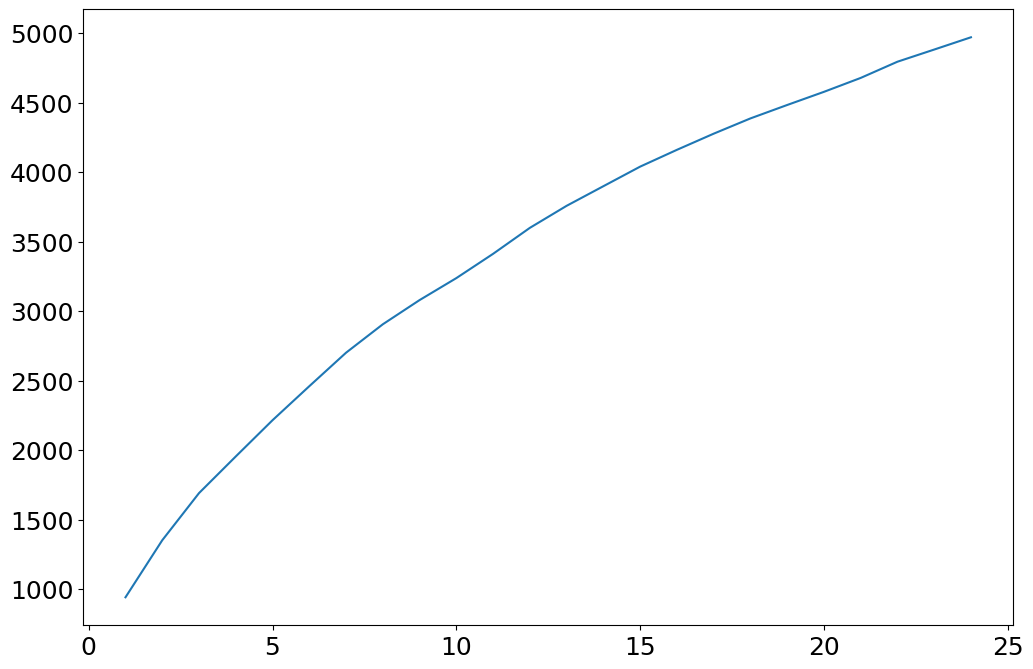

In [24]:
persistence_values = range(1, 25)
scores = list()
for p in persistence_values:
    # walk-forward validation
    history = [x for x in x_train.values]
    predictions = list()
    for i in range(len(x_valid)):
    # make prediction
        yhat = history[-p]
        predictions.append(yhat)
        # observation
        history.append(x_valid[i])
    # report performance
    rmse = sqrt(mean_squared_error(x_valid, predictions))
    scores.append(rmse)
    print('p=%d RMSE:%.3f' % (p, rmse))
# plot scores over persistence values
plt.plot(persistence_values, scores)

size = plt.gcf()
size.set_size_inches(12,8)
plt.show()

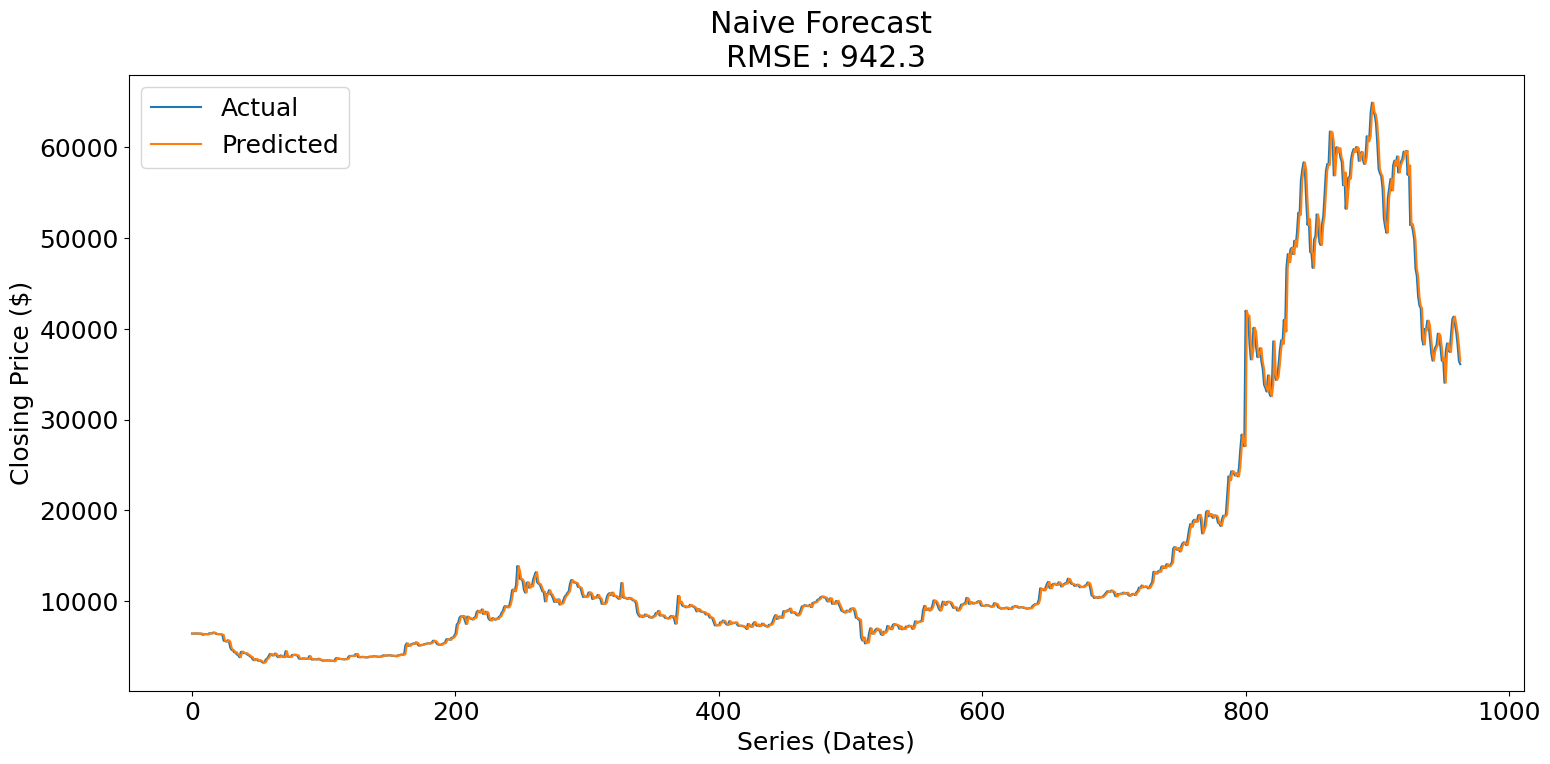

In [25]:
history = [x for x in x_train]
predictions = list()
for i in range(len(x_valid.values)):
    # make prediction
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    history.append(x_valid[i])

rmse = round(sqrt(mean_squared_error(x_valid, predictions)),2)

# plot predictions vs observations
plt.plot(x_valid.values, label = 'Actual')
plt.plot(predictions, label = 'Predicted')
plt.xlabel('Series (Dates)')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.title('Naive Forecast \n' + 'RMSE : ' + str(rmse))
size = plt.gcf()
size.set_size_inches(18,8)
plt.show()

In [26]:
rmse = 

SyntaxError: invalid syntax (567816991.py, line 1)